# Import Libraries and Define Functions

In [474]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
import random

In [475]:
# This function returns a boolean value to determine whether we should look at sympathy play.
# If the return is greater than or less than 2 standard deviations from the mean return, multiplied
# by the correlation between the two stocks, then we should look for sympathy play.

# Stock 1 - dataframe of the stock who's return you are looking at
# str1 - string code of stock 1 (ex. JNJ, LLY, etc.)
# str2 - string code of the stock you are looking at for sympathy play
# correlation - the correlation matrix we saved in getting_data.ipynb
# metrics - the metrics df we saved in getting_data.ipynb
# date_pos - the date you are looking at, either as the index of the dataframe or as a date string ('YYYY-MM-DD')
def sympathyplay(stock1, str1, stock_list, correlation, metrics, date_pos):
    corr_sum = (np.sum(correlation[str1])-1)/(len(stock_list)-1)
    prhs = (metrics[str1]['mean'] + metrics[str1]['std'])*abs(corr_sum)
    nrhs = (metrics[str1]['mean'] - metrics[str1]['std'])*abs(corr_sum)
    if stock1['Return'][date_pos] >= prhs or stock1['Return'][date_pos] <= nrhs:
        return True
    else:
        return False
    
# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        X.append(a)
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

In [476]:
f = open('data/Pharma/Errors.txt','a')

In [477]:
def NaiveTime(test, train, dt_list, Return_df, stock):
    # average forcast
    mean_value = Return_df[stock].mean()
    test['naive_average_forecast'] = mean_value
    train['naive_average_forecast'] = mean_value

    # Calculate errors for training set
    train_mae = mean_absolute_error(train[stock], train['naive_average_forecast'])
    train_mse = mean_squared_error(train[stock], train['naive_average_forecast'])
    train_mape = mean_absolute_percentage_error(train[stock], train['naive_average_forecast'])

    # Calculate errors for test set
    test_mae = mean_absolute_error(test[stock], test['naive_average_forecast'])
    test_mse = mean_squared_error(test[stock], test['naive_average_forecast'])
    test_mape = mean_absolute_percentage_error(test[stock], test['naive_average_forecast'])

    f = open('data/Pharma/Errors.txt','a')
    f.write(f'Naive\t{stock}\tTraining MAE: {train_mae}\tTraining MSE: {train_mse}\tTraining MAPE: {train_mape}%\n\t\t\tTest MAE: {test_mae}\tTest MSE: {test_mse}\tTest MAPE: {test_mape}%\n')
    f.close()

    # Visualize the comparison between prediction and true data
    plt.figure(figsize=(14, 7))
    plt.plot(train[stock], label='Training Data')
    plt.plot(train['naive_average_forecast'], label='Training Naive Average Forecast', linestyle='--')
    plt.plot(test[stock], label='Test Data')
    plt.plot(test['naive_average_forecast'], label='Test Naive Average Forecast', linestyle='--')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Comparison of True Data and Naive Average Forecast')
    plt.xticks(ticks=dt_list, rotation=45)  # Rotate date labels for better readability
    plt.savefig(f'data/Pharma/Figures/{stock}/NaiveTime')
    plt.close()
    return

In [478]:
def RollingAve(test, train, dt_list, stock):
    # Define the window size for the rolling average
    window_size = 90

    # Calculate the rolling average for the training data
    train['rolling_average'] = train[stock].rolling(window=window_size).mean()

    # Use the rolling average to forecast the training set (excluding initial NaN values)
    train['rolling_average_forecast'] = train['rolling_average']

    # Use the last rolling average value to forecast the test set
    last_rolling_avg = train['rolling_average'].iloc[-1]
    test['rolling_average_forecast'] = last_rolling_avg

    # Calculate errors for training set (drop NaN values from rolling average forecast)
    train_non_nan = train.dropna(subset=['rolling_average_forecast'])
    train_mae = mean_absolute_error(train_non_nan[stock], train_non_nan['rolling_average_forecast'])
    train_mse = mean_squared_error(train_non_nan[stock], train_non_nan['rolling_average_forecast'])
    train_mape = mean_absolute_percentage_error(train_non_nan[stock], train_non_nan['rolling_average_forecast'])

    # Calculate errors for test set
    test_mae = mean_absolute_error(test[stock], test['rolling_average_forecast'])
    test_mse = mean_squared_error(test[stock], test['rolling_average_forecast'])
    test_mape = mean_absolute_percentage_error(test[stock], test['rolling_average_forecast'])

    f = open('data/Pharma/Errors.txt','a')
    f.write(f'RollAve\t{stock}\tTraining MAE: {train_mae}\tTraining MSE: {train_mse}\tTraining MAPE: {train_mape}%\n\t\t\tTest MAE: {test_mae}\tTest MSE: {test_mse}\tTest MAPE: {test_mape}%\n')
    f.close()

    # Visualize the comparison between prediction and true data
    plt.figure(figsize=(14, 7))
    plt.plot(train[stock], label='Training Data')
    plt.plot(train['rolling_average_forecast'], label='Training Rolling Average Forecast', linestyle='--')
    plt.plot(test[stock], label='Test Data')
    plt.plot(test['rolling_average_forecast'], label='Test Rolling Average Forecast', linestyle='--')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel(stock)
    plt.title('Comparison of True Data and Rolling Average Forecast')
    plt.xticks(ticks=dt_list, rotation=45)  # Rotate date labels for better readability
    plt.savefig(f'data/Pharma/Figures/{stock}/RollingAve')
    plt.close()
    return

In [479]:
def SimpleSmooth(test, train, dt_list, stock):
    # Fit simple exponential smoothing to the training data
    fit_model = SimpleExpSmoothing(train[stock]).fit(optimized=True)

    # Use the fitted model to forecast both the training and test sets
    train['simple_exp_smoothing_forecast'] = fit_model.fittedvalues
    test['simple_exp_smoothing_forecast'] = fit_model.forecast(len(test))

    test = test[:-2]

    # Calculate errors for training set
    train_mae = mean_absolute_error(train[stock], train['simple_exp_smoothing_forecast'])
    train_mse = mean_squared_error(train[stock], train['simple_exp_smoothing_forecast'])
    train_mape = mean_absolute_percentage_error(train[stock], train['simple_exp_smoothing_forecast'])

    # Calculate errors for test set
    test_mae = mean_absolute_error(test[stock], fit_model.forecast(len(test)))
    test_mse = mean_squared_error(test[stock], fit_model.forecast(len(test)))
    test_mape = mean_absolute_percentage_error(test[stock], fit_model.forecast(len(test)))

    f = open('data/Pharma/Errors.txt','a')
    f.write(f'SimpSmooth\t{stock}\tTraining MAE: {train_mae}\tTraining MSE: {train_mse}\tTraining MAPE: {train_mape}%\n\t\t\tTest MAE: {test_mae}\tTest MSE: {test_mse}\tTest MAPE: {test_mape}%\n')
    f.close()

    # Visualize the comparison between prediction and true data
    plt.figure(figsize=(14, 7))
    plt.plot(train[stock], label='Training Data')
    plt.plot(train['simple_exp_smoothing_forecast'], label='Training Simple Exp Smoothing Forecast', linestyle='--')
    plt.plot(test[stock], label='Test Data')
    plt.plot(fit_model.forecast(len(test)), label='Test Simple Exp Smoothing Forecast', linestyle='--')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Comparison of True Data and Simple Exp Smoothing Forecast')
    plt.xticks(ticks=dt_list, rotation=45)  # Rotate date labels for better readability
    plt.savefig(f'data/Pharma/Figures/{stock}/SimpleSmooth')
    plt.close()
    return

In [480]:
def DoubleExpSmooth(test, train, dt_list, stock):
    model = Holt(train[stock])

    fit_model = model.fit(optimized=True)

    # Use the fitted model to forecast both the training and test sets
    train['double_exp_smoothing_forecast'] = fit_model.fittedvalues
    test['double_exp_smoothing_forecast'] = fit_model.forecast(len(test))

    test = test[:-2]

    # Calculate errors for training set
    train_mae = mean_absolute_error(train[stock], train['double_exp_smoothing_forecast'])
    train_mse = mean_squared_error(train[stock], train['double_exp_smoothing_forecast'])
    train_mape = mean_absolute_percentage_error(train[stock], train['double_exp_smoothing_forecast'])

    # Calculate errors for test set
    test_mae = mean_absolute_error(test[stock], fit_model.forecast(len(test)))
    test_mse = mean_squared_error(test[stock], fit_model.forecast(len(test)))
    test_mape = mean_absolute_percentage_error(test[stock], fit_model.forecast(len(test)))

    f = open('data/Pharma/Errors.txt','a')
    f.write(f'DSmooth\t{stock}\tTraining MAE: {train_mae}\tTraining MSE: {train_mse}\tTraining MAPE: {train_mape}%\n\t\t\tTest MAE: {test_mae}\tTest MSE: {test_mse}\tTest MAPE: {test_mape}%\n')
    f.close()

    # Visualize the comparison between prediction and true data
    plt.figure(figsize=(14, 7))
    plt.plot(train[stock], label='Training Data')
    plt.plot(train['double_exp_smoothing_forecast'], label='Training double Exp Smoothing Forecast', linestyle='--')
    plt.plot(test[stock], label='Test Data')
    plt.plot(fit_model.forecast(len(test)), label='Test double Exp Smoothing Forecast', linestyle='--')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Comparison of True Data and Double Exp Smoothing Forecast')
    plt.xticks(ticks=dt_list,rotation=45)  # Rotate date labels for better readability
    plt.savefig(f'data/Pharma/Figures/{stock}/DoubleExpSmooth')
    plt.close()
    return

In [481]:
def TripleExpSmooth(test, train, dt_list, stock):
    model = ExponentialSmoothing(train[stock])
    fit_model = model.fit(optimized=True)

    # Use the fitted model to forecast both the training and test sets
    train['triple_exp_smoothing_forecast'] = fit_model.fittedvalues
    test['triple_exp_smoothing_forecast'] = fit_model.forecast(len(test))

    test = test[:-2]

    # Function to calculate MAPE
    def mean_absolute_percentage_error(y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # Calculate errors for training set
    train_mae = mean_absolute_error(train[stock], train['triple_exp_smoothing_forecast'])
    train_mse = mean_squared_error(train[stock], train['triple_exp_smoothing_forecast'])
    train_mape = mean_absolute_percentage_error(train[stock], train['triple_exp_smoothing_forecast'])

    # Calculate errors for test set
    test_mae = mean_absolute_error(test[stock], fit_model.forecast(len(test)))
    test_mse = mean_squared_error(test[stock], fit_model.forecast(len(test)))
    test_mape = mean_absolute_percentage_error(test[stock], fit_model.forecast(len(test)))

    f = open('data/Pharma/Errors.txt','a')
    f.write(f'TSmooth\t{stock}\tTraining MAE: {train_mae}\tTraining MSE: {train_mse}\tTraining MAPE: {train_mape}%\n\t\t\tTest MAE: {test_mae}\tTest MSE: {test_mse}\tTest MAPE: {test_mape}%\n')
    f.close()

    # Visualize the comparison between prediction and true data
    plt.figure(figsize=(14, 7))
    plt.plot(train[stock], label='Training Data')
    plt.plot(train['triple_exp_smoothing_forecast'], label='Training triple Exp Smoothing Forecast', linestyle='--')
    plt.plot(test[stock], label='Test Data')
    plt.plot(fit_model.forecast(len(test)), label='Test triple Exp Smoothing Forecast', linestyle='--')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Comparison of True Data and Triple Exp Smoothing Forecast')
    plt.xticks(ticks=dt_list,rotation=45)  # Rotate date labels for better readability
    plt.savefig(f'data/Pharma/Figures/{stock}/TripleExpSmooth')
    plt.close()
    return

In [482]:
def ARIMA_Forecast(test, train, dt_list, stock):
    # Define the order of the ARIMA model (p, d, q)
    p = 1  # AR parameter
    d = 0  # I(d) parameter (degree of differencing)
    q = 0  # MA parameter

    # Fit ARIMA model
    model = ARIMA(train[stock], order=(p, d, q))
    fit_model = model.fit()

    # Use the fitted model to forecast both the training and test sets
    train['arima_forecast'] = fit_model.fittedvalues
    test['arima_forecast'] = fit_model.forecast(steps=len(test))

    test = test[:-2] # I don't know why, the last two rows are always nans

    # Calculate errors for training set
    train_mae = mean_absolute_error(train[stock], train['arima_forecast'])
    train_mse = mean_squared_error(train[stock], train['arima_forecast'])
    train_mape = mean_absolute_percentage_error(train[stock], train['arima_forecast'])

    # Calculate errors for test set
    test_mae = mean_absolute_error(test[stock], fit_model.forecast(steps=len(test)))
    test_mse = mean_squared_error(test[stock], fit_model.forecast(steps=len(test)))
    test_mape = mean_absolute_percentage_error(test[stock], fit_model.forecast(steps=len(test)))

    f = open('data/Pharma/Errors.txt','a')
    f.write(f'ARIMA\t{stock}\tTraining MAE: {train_mae}\tTraining MSE: {train_mse}\tTraining MAPE: {train_mape}%\n\t\t\tTest MAE: {test_mae}\tTest MSE: {test_mse}\tTest MAPE: {test_mape}%\n')
    f.close()

    # Visualize the comparison between prediction and true data
    plt.figure(figsize=(14, 7))
    plt.plot(train[stock], label='Training Data')
    plt.plot(train['arima_forecast'], label='Training ARIMA Forecast', linestyle='--')
    plt.plot(test[stock], label='Test Data')
    plt.plot(fit_model.forecast(steps=len(test)), label='Test ARIMA Forecast', linestyle='--')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Comparison of True Data and ARIMA Forecast')
    plt.xticks(ticks=dt_list,rotation=45)  # Rotate date labels for better readability
    plt.savefig(f'data/Pharma/Figures/{stock}/ARIMA')
    plt.close()
    return


In [483]:
def SARIMAX_Forecast(test, train, dt_list, Return_df, stock):
    # Plot Autocorrelation Function (ACF)
    plt.figure(figsize=(12, 6))
    plot_acf(Return_df[stock], lags=40, title='Autocorrelation Function (ACF)')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.savefig(f'data/Pharma/Figures/{stock}/ACF')
    plt.close()

    # Plot Partial Autocorrelation Function (PACF)
    plt.figure(figsize=(12, 6))
    plot_pacf(Return_df[stock], lags=40, title='Partial Autocorrelation Function (PACF)')
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')
    plt.savefig(f'data/Pharma/Figures/{stock}/PACF')
    plt.close()

    # Define the order of the ARIMA model (p, d, q)
    p = 1  # AR parameter
    d = 0  # I(d) parameter (degree of differencing)
    q = 0  # MA parameter

    SP = f'{stock}_SP'

    # Fit ARIMA model
    model = SARIMAX(train[stock], order=(p, d, q), seasonal_order=(0,0,0,10), exog=train[SP])
    fit_model = model.fit()

    # Use the fitted model to forecast both the training and test sets
    train['sarimax_forecast'] = fit_model.fittedvalues
    test['sarimax_forecast'] = fit_model.forecast(steps=len(test),exog=test[SP])

    test = test[:-2] # I don't know why, the last two rows are always nans

    # Calculate errors for training set
    train_mae = mean_absolute_error(train[stock], train['sarimax_forecast'])
    train_mse = mean_squared_error(train[stock], train['sarimax_forecast'])
    train_mape = mean_absolute_percentage_error(train[stock], train['sarimax_forecast'])

    # Calculate errors for test set
    test_mae = mean_absolute_error(test[stock], fit_model.forecast(steps=len(test),exog=test[SP]))
    test_mse = mean_squared_error(test[stock], fit_model.forecast(steps=len(test),exog=test[SP]))
    test_mape = mean_absolute_percentage_error(test[stock], fit_model.forecast(steps=len(test),exog=test[SP]))

    f = open('data/Pharma/Errors.txt','a')
    f.write(f'SARIMAX\t{stock}\tTraining MAE: {train_mae}\tTraining MSE: {train_mse}\tTraining MAPE: {train_mape}%\n\t\t\tTest MAE: {test_mae}\tTest MSE: {test_mse}\tTest MAPE: {test_mape}%\n')
    f.close()

    # Visualize the comparison between prediction and true data
    plt.figure(figsize=(14, 7))
    plt.plot(train[stock], label='Training Data')
    plt.plot(train['sarimax_forecast'], label='Training SARIMAX Forecast', linestyle='--')
    plt.plot(test[stock], label='Test Data')
    plt.plot(fit_model.forecast(steps=len(test),exog=test[SP]), label='Test SARIMAX Forecast', linestyle='--')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Comparison of True Data and SARIMAX Forecast')
    plt.xticks(ticks=dt_list,rotation=45)  # Rotate date labels for better readability
    plt.savefig(f'data/Pharma/Figures/{stock}/SARIMAX')
    plt.close()
    return

In [484]:
def LSTM_Forecast(dt_list,df, stock):
    # Set the random seed for NumPy
    np.random.seed(42)
    # Set the random seed for Python's built-in random module
    random.seed(42)
    # Set the random seed for TensorFlow
    tf.random.set_seed(42)

    # Train-test split
    train_size = int(len(df) * 0.95)
    train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

    # Extract values
    train_values = train_data[stock].values.reshape(-1, 1)
    test_values = test_data[stock].values.reshape(-1, 1)

    # Scale the training data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_train_data = scaler.fit_transform(train_values)

    # Scale the testing data using the same scaler
    scaled_test_data = scaler.transform(test_values)

    time_step = 1
    X_train, y_train = create_dataset(scaled_train_data, time_step)
    X_test, y_test = create_dataset(scaled_test_data, time_step)

    # Reshape input to be [samples, time steps, features] which is required for LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, batch_size=25, epochs=100)


    # Predictions for training set
    train_predict = model.predict(X_train)
    # Predictions for testing set
    test_predict = model.predict(X_test)

    # Transform back to original form
    train_predict = scaler.inverse_transform(train_predict)
    y_train = scaler.inverse_transform([y_train])
    test_predict = scaler.inverse_transform(test_predict)
    y_test = scaler.inverse_transform([y_test])


    # Calculate MAPE
    train_mape = mean_absolute_error(y_train[0], train_predict[:,0])
    test_mape = mean_absolute_error(y_test[0], test_predict[:,0])

    f = open('data/Pharma/Errors.txt','a')
    f.write(f'LSTM\t{stock}\tTraining MAE: {train_mae}\tTesting MAE: {test_mae}\n')
    f.close()

    # Plotting
    plt.figure(figsize=(12, 6))

    # Plot original data
    plt.plot(df[stock], label='Original Data')

    # Plot predictions with dates
    lin = np.linspace(len(train_predict), len(train_predict)+len(test_predict), len(test_predict))
    plt.plot(train_predict, label='Train Prediction')
    plt.plot(lin, test_predict, label='Test Prediction')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'Comparison of True Data and LSTM Forecast')
    plt.xticks(ticks=dt_list,rotation=45)  # Rotate date labels for better readability
    plt.savefig(f'data/Pharma/Figures/{stock}/LSTM')
    plt.close()
    return

In [485]:
def LSTM_Forecast_p1(dt_list, df, stock):
    # Set the random seed for NumPy
    np.random.seed(42)
    # Set the random seed for Python's built-in random module
    random.seed(42)
    # Set the random seed for TensorFlow
    tf.random.set_seed(42)

    # Train-test split
    train_size = int(len(df) * 0.95)
    train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

    SP = f'{stock}_SP'

    # Extract values for the target column and the additional feature
    train_values = train_data[[stock, SP]].values
    test_values = test_data[[stock, SP]].values

    # Scale the training data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_train_data = scaler.fit_transform(train_values)

    # Scale the testing data using the same scaler
    scaled_test_data = scaler.transform(test_values)

    time_step = 1
    X_train, y_train = create_dataset(scaled_train_data, time_step)
    X_test, y_test = create_dataset(scaled_test_data, time_step)

    # Reshape input to be [samples, time steps, features] which is required for LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, batch_size=25, epochs=100)

    # Predictions for training set
    train_predict = model.predict(X_train)
    # Predictions for testing set
    test_predict = model.predict(X_test)

    # Transform back to original form
    train_predict = scaler.inverse_transform(np.hstack((train_predict, np.zeros((train_predict.shape[0], 1)))))
    train_predict = train_predict[:,0]

    y_train = scaler.inverse_transform(np.hstack((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], 1)))))
    y_train = y_train[:,0]

    test_predict = scaler.inverse_transform(np.hstack((test_predict, np.zeros((test_predict.shape[0], 1)))))
    test_predict = test_predict[:,0]

    y_test = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1)))))
    y_test = y_test[:,0]

    # Calculate MAPE
    train_mae = mean_absolute_error(y_train, train_predict)
    test_mae = mean_absolute_error(y_test, test_predict)

    # Plotting
    plt.figure(figsize=(12, 6))

    # Plot original data
    plt.plot(df[stock], label='Original Data')

    f = open('data/Pharma/Errors.txt','a')
    f.write(f'LSTM+1\t{stock}\tTraining MAE: {train_mae}\tTesting MAE: {test_mae}\n')
    f.close()


    # Plot predictions with dates
    lin = np.linspace(len(train_predict), len(train_predict)+len(test_predict), len(test_predict))
    plt.plot(train_predict, label='Train Prediction')
    plt.plot(lin, test_predict, label='Test Prediction')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'Comparison of True Data and LSTM+1 Forecast')
    plt.xticks(ticks=dt_list,rotation=45)  # Rotate date labels for better readability
    plt.savefig(f'data/Pharma/Figures/{stock}/LSTMp1')
    plt.close()
    return

# Gather Data

In [486]:
# Be sure to change your sector path! This will read in all the data saved by getting_data.ipynb
sector_path = 'data/Pharma/'
correlation_matrix = pd.read_csv(f'{sector_path}Correlation.csv', index_col=0)
df_metrics = pd.read_csv(f'{sector_path}Metrics.csv', index_col=0)
stock_string = ['LLY', 'JNJ', 'ABBV', 'AZN', 'NVS', 'CVS', 'WBA', 'NVO',
                'PFE', 'TCNNF', 'MRK']
all_returns = []
allc2hReturn = []

In [487]:
# These are the stocks in the phara sector, you should change these for your own sector.
LLY = pd.read_csv(f'{sector_path}{stock_string[0]}.csv', index_col=0)
JNJ = pd.read_csv(f'{sector_path}{stock_string[1]}.csv', index_col=0)
ABBV = pd.read_csv(f'{sector_path}{stock_string[2]}.csv', index_col=0)
AZN = pd.read_csv(f'{sector_path}{stock_string[3]}.csv', index_col=0)
NVS = pd.read_csv(f'{sector_path}{stock_string[4]}.csv', index_col=0)
CVS = pd.read_csv(f'{sector_path}{stock_string[5]}.csv', index_col=0)
WBA = pd.read_csv(f'{sector_path}{stock_string[6]}.csv', index_col=0)
NVO = pd.read_csv(f'{sector_path}{stock_string[7]}.csv', index_col=0)
PFE = pd.read_csv(f'{sector_path}{stock_string[8]}.csv', index_col=0)
TCNNF = pd.read_csv(f'{sector_path}{stock_string[9]}.csv', index_col=0)
MRK = pd.read_csv(f'{sector_path}{stock_string[10]}.csv', index_col=0)

In [488]:
df_list = [LLY, JNJ, ABBV, AZN, NVS, CVS, WBA, NVO, PFE, TCNNF, MRK]

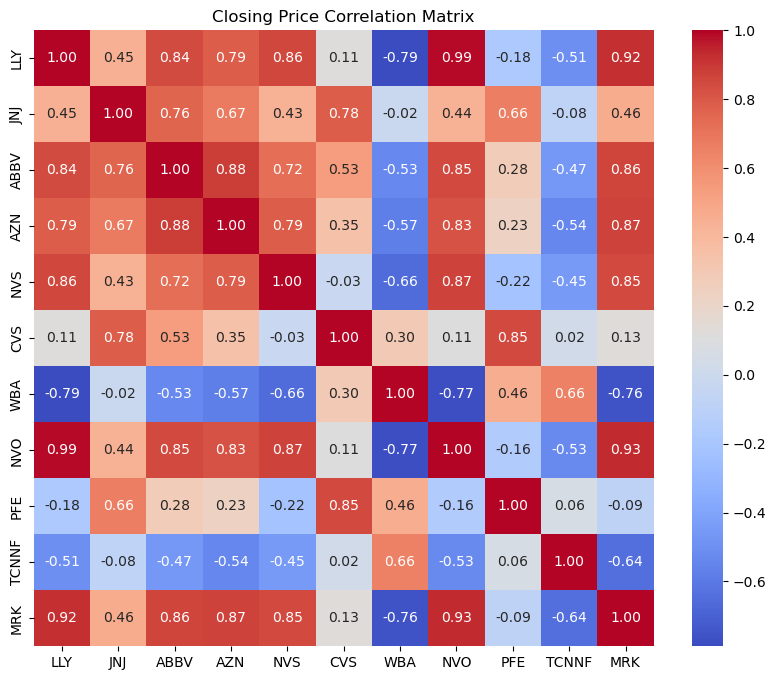

<Figure size 640x480 with 0 Axes>

In [489]:
# Visualize correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Closing Price Correlation Matrix')
plt.show()
plt.savefig('data/Pharma/Figures/CorrelationMatrix')

In [490]:
i=0
for df in df_list:
    Return_series = df['Return']
    Return_series.name = stock_string[i]
    all_returns.append(Return_series)
    i+=1
    
Return_df = pd.concat(all_returns, axis=1)
H_Ret = [0]*len(Return_df)
H_Ret = np.array(H_Ret)

In [491]:
dt_list = []
for i in range(len(Return_df)):
    if i%40 == 0:
        dt_list.append(Return_df.iloc[i].name)

In [492]:
i=0
for df in df_list:
    current_stock = stock_string[i]
    H_Ret_t = []
    for j in range(len(df['Return'])):
        H_Ret_t = np.append(H_Ret_t, sympathyplay(df, current_stock, stock_string, correlation_matrix, df_metrics, j))
    H_Ret_t = np.array(H_Ret_t.astype(int))
    H_Ret = np.maximum(H_Ret, H_Ret_t)
    SP_string = f'{current_stock}_SP'
    Return_df[SP_string] = H_Ret
    Return_df[SP_string] = Return_df[SP_string].shift(1)

    i+=1

Return_df = Return_df.dropna()



C:\Users\ntamm\AppData\Local\Temp\ipykernel_38476\4202165160.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if stock1['Return'][date_pos] >= prhs or stock1['Return'][date_pos] <= nrhs:
C:\Users\ntamm\AppData\Local\Temp\ipykernel_38476\4202165160.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if stock1['Return'][date_pos] >= prhs or stock1['Return'][date_pos] <= nrhs:
C:\Users\ntamm\AppData\Local\Temp\ipykernel_38476\4202165160.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame beha

In [493]:
train_size = 0.95
train, test = train_test_split(Return_df, train_size=train_size, shuffle=False)

# Naive Time Series

In [494]:
for stock in stock_string:
    NaiveTime(test, train, dt_list, Return_df, stock)

# Rolling Average Time Series

In [495]:
for stock in stock_string:
    RollingAve(test, train, dt_list, stock)

# Simple Smoothing Time Series

In [496]:
for stock in stock_string:
    SimpleSmooth(test, train, dt_list, stock)

c:\Users\ntamm\.conda\envs\erdos_may_2024\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ntamm\.conda\envs\erdos_may_2024\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ntamm\.conda\envs\erdos_may_2024\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\ntamm\.conda\envs\erdos_may_2024\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an inte

# Double Exp Smoothing

In [497]:
for stock in stock_string:
    DoubleExpSmooth(test, train, dt_list, stock)

c:\Users\ntamm\.conda\envs\erdos_may_2024\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ntamm\.conda\envs\erdos_may_2024\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ntamm\.conda\envs\erdos_may_2024\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\ntamm\.conda\envs\erdos_may_2024\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an inte

# Triple Exp Smoothing

In [498]:
for stock in stock_string:
    TripleExpSmooth(test, train, dt_list, stock)

c:\Users\ntamm\.conda\envs\erdos_may_2024\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ntamm\.conda\envs\erdos_may_2024\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ntamm\.conda\envs\erdos_may_2024\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\ntamm\.conda\envs\erdos_may_2024\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an inte

# ARIMA

In [499]:
for stock in stock_string:
    ARIMA_Forecast(test, train, dt_list, stock)

c:\Users\ntamm\.conda\envs\erdos_may_2024\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ntamm\.conda\envs\erdos_may_2024\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ntamm\.conda\envs\erdos_may_2024\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ntamm\.conda\envs\erdos_may_2024\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warning

# SRIMAX

In [500]:
for stock in stock_string:
    SARIMAX_Forecast(test, train, dt_list, Return_df, stock)

c:\Users\ntamm\.conda\envs\erdos_may_2024\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ntamm\.conda\envs\erdos_may_2024\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ntamm\.conda\envs\erdos_may_2024\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ntamm\.conda\envs\erdos_may_2024\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

# LSTM

In [501]:
for stock in stock_string:
    LSTM_Forecast(dt_list,Return_df, stock)

Epoch 1/100
42/42 [==============================] - 3s 2ms/step - loss: 0.0318
Epoch 2/100
42/42 [==============================] - 0s 2ms/step - loss: 0.0054
Epoch 3/100
42/42 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch 4/100
42/42 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch 5/100
42/42 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch 6/100
42/42 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 7/100
42/42 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch 8/100
42/42 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch 9/100
42/42 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 10/100
42/42 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch 11/100
42/42 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch 12/100
42/42 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 13/100
42/42 [=================

# LSTM +1

In [502]:
for stock in stock_string:
    LSTM_Forecast_p1(dt_list, Return_df, stock)

IndexError: tuple index out of range